In [1]:
import os
import json
import shutil
import pandas as pd
from tqdm import tqdm
from ultralytics import YOLO
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

%matplotlib inline

In [ ]:
def convert_coco_to_yolo(coco_file, source_images_dir, output_dir):
    with open(coco_file, 'r') as f:
        coco_data = json.load(f)

    os.makedirs(f"{output_dir}/images", exist_ok=True)
    os.makedirs(f"{output_dir}/labels", exist_ok=True)

    categories = coco_data.get("categories", [])
    category_mapping = {cat["id"]: idx for idx, cat in enumerate(categories)}

    for annotation in tqdm(coco_data["annotations"], desc="Converting annotations"):
        try:
            image_id = annotation["image_id"]
            bbox = annotation["bbox"]
            category_id = annotation["category_id"]
            image_info = next(img for img in coco_data["images"] if img["id"] == image_id)
            img_filename = image_info["file_name"]
            img_width = image_info["width"]
            img_height = image_info["height"]

            x_min, y_min, width, height = bbox
            x_center = (x_min + width / 2) / img_width
            y_center = (y_min + height / 2) / img_height
            norm_width = width / img_width
            norm_height = height / img_height

            class_id = category_mapping[category_id]
            yolo_line = f"{class_id} {x_center} {y_center} {norm_width} {norm_height}\n"

            txt_filename = os.path.splitext(img_filename)[0] + ".txt"
            with open(os.path.join(output_dir, "labels", txt_filename), "a") as f:
                f.write(yolo_line)

            shutil.copy(
                os.path.join(source_images_dir, img_filename),
                os.path.join(output_dir, "images", img_filename)
            )
        except Exception as e:
            print(f"Error processing annotation {annotation}: {e}")

def split_dataset(output_dir, train_ratio=0.8):
    train_images_dir = os.path.join(output_dir, "train", "images")
    train_labels_dir = os.path.join(output_dir, "train", "labels")

    train_image_files = os.listdir(train_images_dir)
    train_label_files = [f for f in os.listdir(train_labels_dir) if f.endswith(".txt")]

    train_images, val_images = train_test_split(train_image_files, test_size=1-train_ratio, random_state=42)

    final_train_images_dir = r"Weed_Detection_Dataset_For_Yolo\images\train"
    final_val_images_dir = r"Weed_Detection_Dataset_For_Yolo\images\val"
    final_train_labels_dir = r"Weed_Detection_Dataset_For_Yolo\labels\train"
    final_val_labels_dir = r"Weed_Detection_Dataset_For_Yolo\labels\val"

    os.makedirs(final_train_images_dir, exist_ok=True)
    os.makedirs(final_val_images_dir, exist_ok=True)
    os.makedirs(final_train_labels_dir, exist_ok=True)
    os.makedirs(final_val_labels_dir, exist_ok=True)

    for image_file in train_images:
        shutil.copy(os.path.join(train_images_dir, image_file), os.path.join(final_train_images_dir, image_file))
        label_file = os.path.splitext(image_file)[0] + ".txt"
        if label_file in train_label_files:
            shutil.copy(os.path.join(train_labels_dir, label_file), os.path.join(final_train_labels_dir, label_file))

    for image_file in val_images:
        shutil.copy(os.path.join(train_images_dir, image_file), os.path.join(final_val_images_dir, image_file))
        label_file = os.path.splitext(image_file)[0] + ".txt"
        if label_file in train_label_files:
            shutil.copy(os.path.join(train_labels_dir, label_file), os.path.join(final_val_labels_dir, label_file))

    print(f"Dataset prepared with {len(train_images)} training and {len(val_images)} validation images.")


dataset_root = r'Weed_Detection_Dataset_For_Yolo'

if not os.path.exists(dataset_root):
    train_coco = r"Weed_Detection_Dataset\train\_annotations.coco.json"
    train_images = r"Weed_Detection_Dataset\train"
    train_output = r"yolo_format\train"

    test_coco = r"Weed_Detection_Dataset\test\_annotations.coco.json"
    test_images = r"Weed_Detection_Dataset\test"
    test_output = r"yolo_format\test"

    convert_coco_to_yolo(train_coco, train_images, train_output)
    convert_coco_to_yolo(test_coco, test_images, test_output)

    split_dataset(r"yolo_format")

    dataset_root_fixed = dataset_root.replace("\\", "/")
    yaml_path = os.path.join(dataset_root, 'data.yaml')

    os.makedirs(dataset_root, exist_ok=True)
    
    with open(yaml_path, 'w') as f:
        f.write(f"""
path: {dataset_root_fixed}
train: images/train
val: images/val
nc: 2
names: ['crop', 'weed']
""")

Converting annotations: 100%|██████████| 662/662 [00:00<00:00, 1689.86it/s]


Dataset prepared with 1324 training and 331 validation images.


In [2]:
yolo_v8_model = YOLO('yolov8m.pt')

In [3]:
yolo_v8_model.info()

YOLOv8m summary: 169 layers, 25,902,640 parameters, 0 gradients, 79.3 GFLOPs


(169, 25902640, 0, 79.3204224)

In [4]:
print(yolo_v8_model)

YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(48, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(48, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(96, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(96, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(96, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(192, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(96, eps=0.001, momentum=0.03, affine=True, track_running_

In [ ]:
DATA_PATH = r"Weed_Detection_Dataset_For_Yolo\data.yaml"
# DATA_PATH = r"Weed_Detection_Dataset_For_Yolo\data_laptop.yaml"

In [6]:
yolo_v8_model.train(
    data=DATA_PATH,
    epochs=40,
    batch=8,
    imgsz=640,
    seed=6,
    lr0=0.00001,
    weight_decay=0.0001,
    optimizer='Adam',
    save_period=20,
    project='ft_models',
    name='yolo_v8_weed_detection',
    verbose=True,
    augment=True,
)

# yolo_v8_model.train(
#     data=DATA_PATH,
#     epochs=30,
#     batch=16,
#     imgsz=640,
#     seed=6,
#     lr0=0.0001,
#     weight_decay=0.001,
#     optimizer='Adam',
#     save_period=20,
#     project='ft_models',
#     name='yolo_v8_weed_detection',
#     verbose=True,
#     augment=True,
# )

New https://pypi.org/project/ultralytics/8.3.140 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.139  Python-3.10.11 torch-2.4.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4050 Laptop GPU, 6140MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=D:\semester 6\Advanced AI Project\Weed_Detection_Dataset_For_Yolo\data_laptop.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=40, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=1e-05, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8m.pt, momentum=0.937, mosaic=1.0,

train: Scanning D:\semester 6\Advanced AI Project\Weed_Detection_Dataset_For_Yolo\labels\train.cache... 1324 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1324/1324 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.30.1 ms, read: 9.41.2 MB/s, size: 81.3 KB)


val: Scanning D:\semester 6\Advanced AI Project\Weed_Detection_Dataset_For_Yolo\labels\val.cache... 331 images, 0 backgrounds, 0 corrupt: 100%|██████████| 331/331 [00:00<?, ?it/s]


Plotting labels to ft_models\yolo_v8_weed_detection\labels.jpg... 
optimizer: Adam(lr=1e-05, momentum=0.937) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0001), 83 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to ft_models\yolo_v8_weed_detection
Starting training for 40 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/40       3.3G      1.853      1.568      1.706          6        640: 100%|██████████| 166/166 [00:46<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:04<00:00,  4.54it/s]


                   all        331        806      0.753      0.737      0.776      0.382

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/40      3.44G      1.733       1.11      1.575         11        640: 100%|██████████| 166/166 [00:42<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:04<00:00,  4.61it/s]

                   all        331        806      0.753      0.727      0.772      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/40      3.44G      1.683      1.073      1.544         18        640: 100%|██████████| 166/166 [00:42<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:04<00:00,  4.64it/s]

                   all        331        806      0.754      0.744       0.78      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/40      3.55G      1.664       1.04      1.536         17        640: 100%|██████████| 166/166 [00:42<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:04<00:00,  4.65it/s]

                   all        331        806      0.753      0.739      0.782      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/40      3.54G      1.652       1.04      1.531          7        640: 100%|██████████| 166/166 [00:42<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:04<00:00,  4.65it/s]

                   all        331        806      0.752      0.751      0.796      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/40      3.44G      1.659      1.046      1.545          9        640: 100%|██████████| 166/166 [00:42<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:04<00:00,  4.65it/s]

                   all        331        806      0.763      0.741      0.789       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/40      3.54G      1.627      1.004      1.513         24        640: 100%|██████████| 166/166 [00:42<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:04<00:00,  4.66it/s]

                   all        331        806      0.749      0.763      0.792      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/40      3.54G       1.62      1.006      1.504         13        640: 100%|██████████| 166/166 [00:42<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:04<00:00,  4.64it/s]

                   all        331        806      0.756      0.753      0.795      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/40      3.51G      1.636      1.014      1.511         15        640: 100%|██████████| 166/166 [00:42<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:04<00:00,  4.68it/s]

                   all        331        806      0.784      0.736      0.797      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/40      3.45G      1.603     0.9889      1.494          9        640: 100%|██████████| 166/166 [00:42<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:04<00:00,  4.67it/s]

                   all        331        806      0.751      0.756        0.8      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/40      3.54G      1.587     0.9777      1.476          9        640: 100%|██████████| 166/166 [00:42<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:04<00:00,  4.67it/s]

                   all        331        806      0.754      0.759      0.796      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/40      3.52G      1.601     0.9947      1.498          8        640: 100%|██████████| 166/166 [00:42<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:04<00:00,  4.66it/s]

                   all        331        806      0.756      0.744       0.79      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/40      3.53G      1.592     0.9938      1.484         18        640: 100%|██████████| 166/166 [00:42<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:04<00:00,  4.62it/s]

                   all        331        806      0.765      0.742      0.795      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/40      3.46G      1.583     0.9595      1.489         18        640: 100%|██████████| 166/166 [00:41<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:04<00:00,  4.68it/s]

                   all        331        806       0.76      0.734      0.787      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/40      3.52G       1.61     0.9817      1.505         12        640: 100%|██████████| 166/166 [00:42<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:04<00:00,  4.65it/s]

                   all        331        806      0.754      0.756      0.797      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/40      3.53G      1.595      0.974      1.497         18        640: 100%|██████████| 166/166 [00:42<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:04<00:00,  4.65it/s]

                   all        331        806      0.771      0.747      0.796      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/40      3.53G      1.587     0.9683      1.484          8        640: 100%|██████████| 166/166 [00:42<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:04<00:00,  4.64it/s]

                   all        331        806      0.773      0.742        0.8      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/40      3.44G      1.577     0.9722      1.495         12        640: 100%|██████████| 166/166 [00:42<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:04<00:00,  4.64it/s]

                   all        331        806      0.791      0.732        0.8      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/40      3.54G      1.563     0.9381      1.473         20        640: 100%|██████████| 166/166 [00:42<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:04<00:00,  4.66it/s]

                   all        331        806      0.783      0.736      0.803      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/40      3.51G      1.578     0.9603      1.486         14        640: 100%|██████████| 166/166 [00:42<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:04<00:00,  4.65it/s]

                   all        331        806       0.79      0.739      0.804      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/40      3.53G      1.567     0.9605      1.478         10        640: 100%|██████████| 166/166 [00:42<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:04<00:00,  4.63it/s]

                   all        331        806      0.781      0.742        0.8      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/40      3.46G      1.564      0.943      1.471          8        640: 100%|██████████| 166/166 [00:42<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:04<00:00,  4.63it/s]

                   all        331        806      0.772      0.747      0.804      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/40      3.52G      1.556     0.9267      1.454         18        640: 100%|██████████| 166/166 [00:42<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:04<00:00,  4.65it/s]

                   all        331        806      0.781      0.751      0.802      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/40      3.53G      1.562     0.9412      1.465          7        640: 100%|██████████| 166/166 [00:42<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:04<00:00,  4.63it/s]

                   all        331        806      0.791      0.733      0.801      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/40      3.52G      1.575     0.9683      1.472         14        640: 100%|██████████| 166/166 [00:42<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:04<00:00,  4.65it/s]

                   all        331        806      0.792      0.733      0.808      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/40      3.46G      1.566      0.932      1.476          8        640: 100%|██████████| 166/166 [00:42<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:04<00:00,  4.66it/s]

                   all        331        806      0.781      0.739      0.809      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/40      3.51G      1.564     0.9582      1.461         18        640: 100%|██████████| 166/166 [00:42<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:04<00:00,  4.65it/s]

                   all        331        806      0.766      0.739      0.805      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/40      3.53G      1.557     0.9511      1.466          7        640: 100%|██████████| 166/166 [00:42<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:04<00:00,  4.62it/s]

                   all        331        806      0.783      0.724        0.8      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/40      3.53G      1.554     0.9483      1.459          8        640: 100%|██████████| 166/166 [00:42<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:04<00:00,  4.66it/s]

                   all        331        806       0.79      0.732      0.804      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/40      3.46G      1.554      0.951      1.451         14        640: 100%|██████████| 166/166 [00:41<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:04<00:00,  4.66it/s]

                   all        331        806      0.791      0.742      0.808      0.424


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/40      3.55G      1.566     0.9157      1.511          6        640: 100%|██████████| 166/166 [00:42<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:04<00:00,  4.63it/s]

                   all        331        806       0.78       0.73      0.804       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/40      3.55G       1.55     0.8816      1.508          8        640: 100%|██████████| 166/166 [00:42<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:04<00:00,  4.65it/s]

                   all        331        806      0.763      0.754      0.805       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/40      3.53G      1.542     0.8821      1.509          8        640: 100%|██████████| 166/166 [00:42<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:04<00:00,  4.65it/s]

                   all        331        806      0.782      0.741      0.805      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/40      3.46G      1.527     0.8901      1.494         10        640: 100%|██████████| 166/166 [00:42<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:04<00:00,  4.64it/s]

                   all        331        806      0.785      0.741      0.805      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/40      3.54G      1.554     0.8955       1.51          8        640: 100%|██████████| 166/166 [00:42<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:04<00:00,  4.64it/s]

                   all        331        806      0.795      0.741      0.808      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/40      3.54G      1.555     0.8745      1.509          5        640: 100%|██████████| 166/166 [00:42<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:04<00:00,  4.63it/s]

                   all        331        806      0.788      0.741      0.807      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/40      3.54G      1.519     0.8655      1.496         13        640: 100%|██████████| 166/166 [00:42<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:04<00:00,  4.63it/s]

                   all        331        806      0.786      0.741      0.805      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/40      3.44G       1.53      0.882      1.496          9        640: 100%|██████████| 166/166 [00:41<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:04<00:00,  4.65it/s]

                   all        331        806      0.787      0.743      0.807      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/40      3.54G      1.532     0.8936      1.496         12        640: 100%|██████████| 166/166 [00:41<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:04<00:00,  4.66it/s]

                   all        331        806       0.78      0.746      0.805      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/40      3.54G      1.532     0.8844      1.503          8        640: 100%|██████████| 166/166 [00:41<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:04<00:00,  4.67it/s]

                   all        331        806      0.784      0.741      0.807      0.424



40 epochs completed in 0.533 hours.
Optimizer stripped from ft_models\yolo_v8_weed_detection\weights\last.pt, 52.0MB
Optimizer stripped from ft_models\yolo_v8_weed_detection\weights\best.pt, 52.0MB

Validating ft_models\yolo_v8_weed_detection\weights\best.pt...
Ultralytics 8.3.139  Python-3.10.11 torch-2.4.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4050 Laptop GPU, 6140MiB)
Model summary (fused): 92 layers, 25,840,918 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:08<00:00,  2.43it/s]


                   all        331        806      0.792      0.761      0.819       0.43
                  weed        331        806      0.792      0.761      0.819       0.43
Speed: 0.3ms preprocess, 22.3ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to ft_models\yolo_v8_weed_detection


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x00000177837990C0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.0480


image 1/1 G:\College\semester 6\Advanced Artificial Intelligence\Project\Weed_Detection_Dataset\test\ridderzuring_7152_jpg.rf.0ac3068181369e0159e4ea16c9b615a8.jpg: 640x640 5 weeds, 20.5ms
Speed: 1.7ms preprocess, 20.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


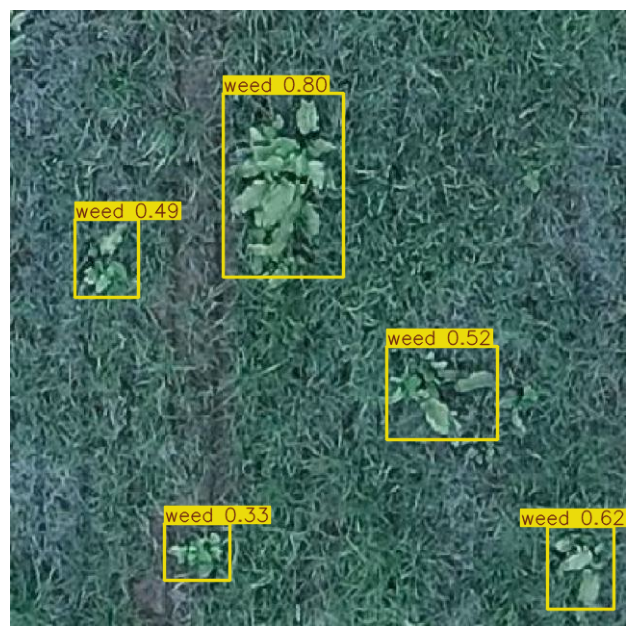

In [ ]:
model_path = r"ft_models\yolo_v8_weed_detection\weights\best.pt"
# model_path = r"ft_models\yolo_v8_weed_detection\weights\best.pt"
model = YOLO(model_path)

image_path = r"Weed_Detection_Dataset\test\ridderzuring_7152_jpg.rf.0ac3068181369e0159e4ea16c9b615a8.jpg"
# image_path = r"Weed_Detection_Dataset\test\ridderzuring_7138_jpg.rf.8df99de831811d8fcdf0277fe3291796.jpg"


predictions = model(image_path)

output_img = predictions[0].plot()

plt.figure(figsize=(8, 8))
plt.imshow(output_img)
plt.axis('off')
plt.show()

In [ ]:
model_path = r"ft_models\yolo_v8_weed_detection\weights\best.pt"
yaml_path = r'Weed_Detection_Dataset_For_Yolo\data.yaml'

# model_path = r"ft_models\yolo_v8_weed_detection\weights\best.pt"
# yaml_path = r'Weed_Detection_Dataset_For_Yolo\data_laptop.yaml'

model = YOLO(model_path)

metrics = model.val(data=yaml_path)

print(f"Precision: {metrics.results_dict['metrics/precision(B)']}")
print(f"Recall: {metrics.results_dict['metrics/recall(B)']}")
print(f"mAP50: {metrics.results_dict['metrics/mAP50(B)']}")
print(f"mAP50-95: {metrics.results_dict['metrics/mAP50-95(B)']}")

Ultralytics 8.3.139  Python-3.10.11 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)
Model summary (fused): 92 layers, 25,840,918 parameters, 0 gradients, 78.7 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 1089.2431.0 MB/s, size: 90.5 KB)


val: Scanning G:\College\semester 6\Advanced Artificial Intelligence\Project\Weed_Detection_Dataset_For_Yolo\labels\val.cache... 331 images, 0 backgrounds, 0 corrupt: 100%|██████████| 331/331 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:07<00:00,  2.87it/s]


                   all        331        806      0.793      0.741      0.809      0.426
                  weed        331        806      0.793      0.741      0.809      0.426
Speed: 0.3ms preprocess, 17.2ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to runs\detect\val
Precision: 0.7933979058666748
Recall: 0.7406947890818859
mAP50: 0.8087078740186979
mAP50-95: 0.4255379455944481


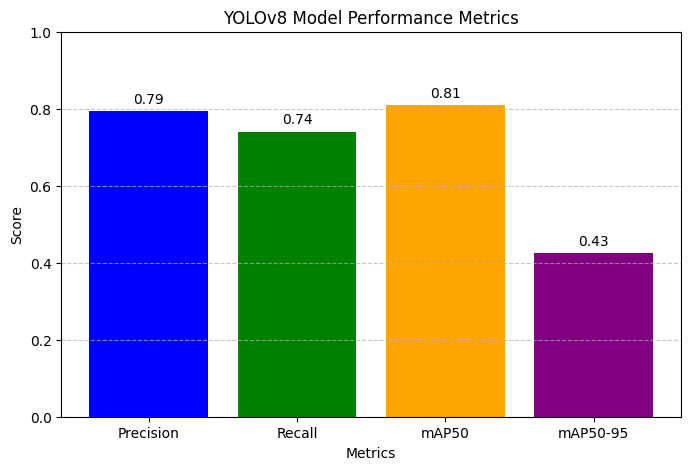

In [4]:
precision = metrics.results_dict['metrics/precision(B)']
recall = metrics.results_dict['metrics/recall(B)']
map50 = metrics.results_dict['metrics/mAP50(B)']
map5095 = metrics.results_dict['metrics/mAP50-95(B)']

metrics_names = ['Precision', 'Recall', 'mAP50', 'mAP50-95']
metrics_values = [precision, recall, map50, map5095]

plt.figure(figsize=(8, 5))
plt.bar(metrics_names, metrics_values, color=['blue', 'green', 'orange', 'purple'])
plt.ylim(0, 1)
plt.title("YOLOv8 Model Performance Metrics")
plt.ylabel("Score")
plt.xlabel("Metrics")
plt.grid(axis='y', linestyle='--', alpha=0.7)

for i, v in enumerate(metrics_values):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontsize=10)

plt.show()


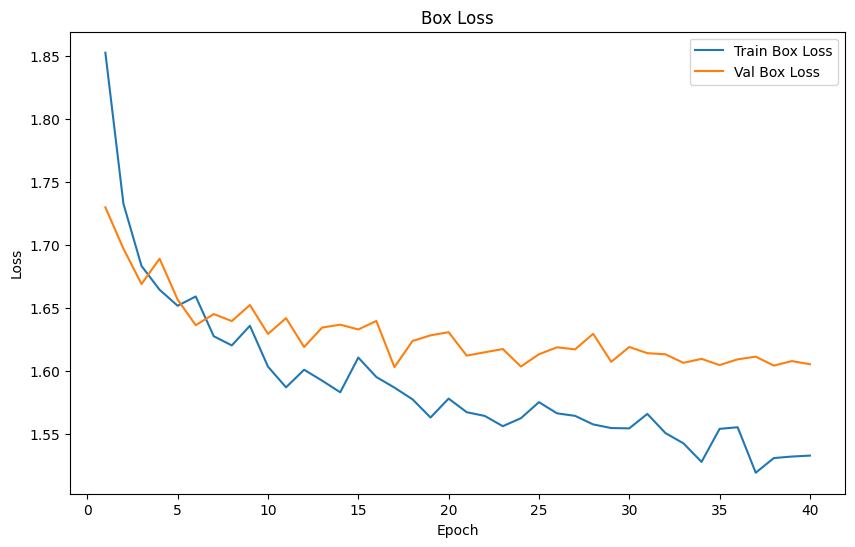

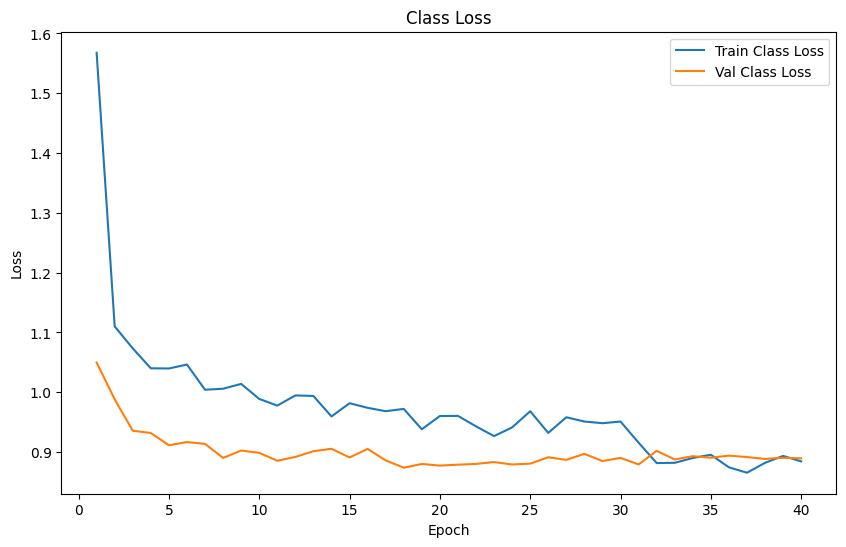

In [ ]:
csv_path = r'ft_models\yolo_v8_weed_detection\results.csv'

data = pd.read_csv(csv_path)

plt.figure(figsize=(10, 6))
plt.plot(data['epoch'], data['train/box_loss'], label='Train Box Loss')
plt.plot(data['epoch'], data['val/box_loss'], label='Val Box Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Box Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(data['epoch'], data['train/cls_loss'], label='Train Class Loss')
plt.plot(data['epoch'], data['val/cls_loss'], label='Val Class Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Class Loss')
plt.legend()
plt.show()

